## Algorithm

### Importing the libraries

In [7]:
# Importing necessary libraries
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import roc_auc_score as roc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import pairwise_kernels as apply_kernel
from shape_dd import shape, shape_modified
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import multiprocessing
from multiprocessing.pool import Pool
from tqdm import tqdm
import os
import random
import time
from gen_data import gen_random, gen_gradual_drift



### Generating the data

In [2]:
# Generate synthetic data with known drift points
X, y = gen_random(number=10,  # number of change points
                 dims=2,     # number of dimensions
                 intens=0.5, # intensity of drift
                 dist="unif",# distribution type
                 alt=True,   # alternating drift
                 length=10000) # length of sequence


In [3]:
X


array([[0.62887696, 0.88905119],
       [0.32932463, 0.57580803],
       [0.7381077 , 0.91898341],
       ...,
       [0.93753417, 0.0157159 ],
       [0.4855221 , 0.0166742 ],
       [0.29436437, 0.1395374 ]])

In [4]:
y


array([0., 0., 0., ..., 0., 0., 0.])

### Batch function to split the datas into batches to process

In [5]:
# Batch function to split the data into chunks with no overlap
def batch(X, chunk_size, overlap=0): # Change overlap to 0
    shift = chunk_size-overlap
    res = []
    for i in range(int(X.shape[0]/(shift))-int(chunk_size/shift)+1):
        res.append( X[i*shift : min(chunk_size + i*shift, X.shape[0])] )
    return res


In [6]:
batches = batch(np.arange(X.shape[0]), chunk_size= 100)


### Ploting the generated data

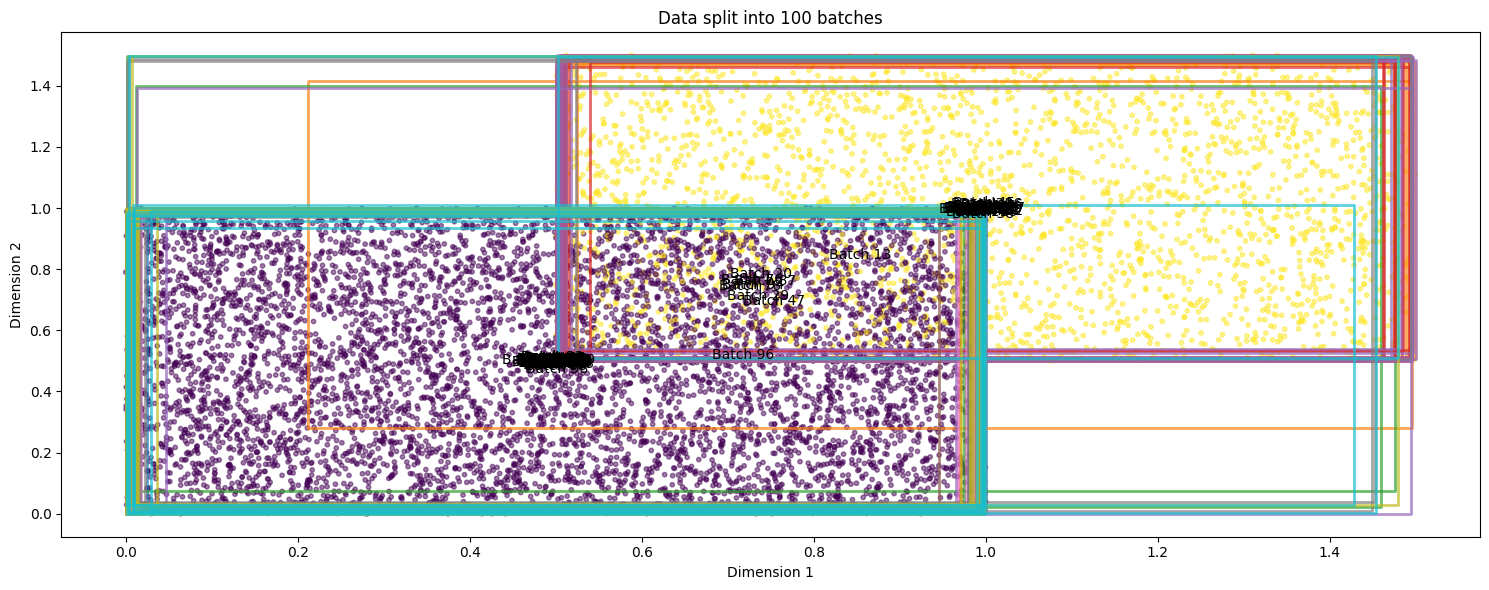

In [7]:
# Function to plot the batches
def plot_batches(X, batches, y=None):
    plt.figure(figsize=(15, 6))
    
    # Plot the first two dimensions of the data
    if X.shape[1] >= 2:
        plt.scatter(X[:, 0], X[:, 1], c=y if y is not None else 'blue', 
                   alpha=0.5, s=10, cmap='viridis')
        
        # Highlight the batches with different colors
        colors = plt.cm.tab10(np.linspace(0, 1, len(batches)))
        
        for i, batch_indices in enumerate(batches):
            batch_start = min(batch_indices)
            batch_end = max(batch_indices)
            
            # Draw rectangle around the batch
            x_min, x_max = X[batch_indices, 0].min(), X[batch_indices, 0].max()
            y_min, y_max = X[batch_indices, 1].min(), X[batch_indices, 1].max()
            
            plt.plot([x_min, x_max, x_max, x_min, x_min], 
                     [y_min, y_min, y_max, y_max, y_min], 
                     '-', color=colors[i], alpha=0.7, linewidth=2)
            
            # Add batch number
            plt.text((x_min + x_max)/2, (y_min + y_max)/2, f"Batch {i}", 
                    color='black', fontsize=10, ha='center', va='center')
    
    else:
        # If data has only one dimension, plot it against indices
        plt.scatter(range(len(X)), X[:, 0], c=y if y is not None else 'blue', 
                   alpha=0.5, s=10, cmap='viridis')
        
        # Highlight the batches
        for i, batch_indices in enumerate(batches):
            plt.axvspan(min(batch_indices), max(batch_indices), 
                       alpha=0.2, color=plt.cm.tab10(i/10))
            plt.text(np.mean(batch_indices), plt.ylim()[0], f"Batch {i}", 
                    ha='center', va='bottom')
    
    plt.title(f"Data split into {len(batches)} batches")
    plt.xlabel("Dimension 1" if X.shape[1] >= 2 else "Index")
    plt.ylabel("Dimension 2" if X.shape[1] >= 2 else "Value")
    plt.tight_layout()
    plt.show()

# Plot the batches
plot_batches(X, batches, y)


### The Algorithm

In [8]:
# Calculate the shape statistic for the entire dataset
# l1 is the number of points to use for the shape statistic
# chunk_size is the number of points to use for the shape statistic
# n_perm is the number of permutations to use for the shape statistic
# shp = shape(X, l1 = 50, l2 = 100, n_perm = 2500)[:,2]
shp = shape(X, l1 = 50, l2 = 100, n_perm = 2500)
# Run the experiment


In [9]:
# Calculate the shape statistic for each batch
res = []
for b in batches:
    # Get the batch
    X_ = X[b]
    
    # Calculate the drift score for the batch
    drift_score = (y[b][None,:] != y[b][:,None]).sum() / (b.shape[0] * (b.shape[0]-1))

    # Calculate the shape statistic for the batch
    shp_stat_min = float("%.5f" % shp[b, 0].min())
    mmd_stat_min = float("%.5f" % shp[b, 1].min())
    p_value_min = float("%.5f" % shp[b, 2].min())
    
    # Add the results to the list
    result = {
        # "batch_id": i,
        "batch_start": min(b),
        "batch_end": max(b),
        "drift_score": drift_score,
        "shape_stat_min": shp_stat_min,
        "mmd_stat_min": mmd_stat_min,
        "p_value": p_value_min
    }
    res.append(result)

# Convert the results to a DataFrame
res_df = pd.DataFrame(res)




In [10]:
def visualize_results(X, y, results_df):
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot 1: Original data with true drift
    axes[0].scatter(range(len(X)), X[:, 0], c=y if y is not None else 'blue', 
                cmap='coolwarm', alpha=0.6)
    axes[0].set_title('First Dimension with True Drift')
    axes[0].set_ylabel('Value')
    axes[0].grid(True)
    
    # Plot 2: Drift scores (if available)
    if 'drift_score' in results_df.columns:
        batch_centers = (results_df['batch_start'] + results_df['batch_end'])
        axes[1].plot(batch_centers, results_df['drift_score'], 'o-g', label='Drift Score')
        axes[1].set_title('True Drift Score by Batch')
        axes[1].set_ylabel('Drift Score')
        axes[1].grid(True)
        axes[1].legend()
    

    # Plot 4: P-values
    batch_centers = (results_df['batch_start'] + results_df['batch_end'])
    axes[2].plot(batch_centers, results_df['p_value'], 'o-b', label='P-value')
    axes[2].axhline(y=0.05, color='r', linestyle='--', label='Threshold (0.05)')
    axes[2].set_ylim(0, 1)
    axes[2].set_title('ShapeDD P-values by Batch')
    axes[2].set_xlabel('Sample Position')
    axes[2].set_ylabel('P-value')
    axes[2].set_yscale('log')
    axes[2].grid(True)
    axes[2].legend()
    
    # Add true drift change points if available
    if y is not None:
        true_drift_positions = np.where(np.diff(y) != 0)[0]
        for ax in axes:
            for pos in true_drift_positions:
                ax.axvline(x=pos, color='black', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()


### Visualize the result

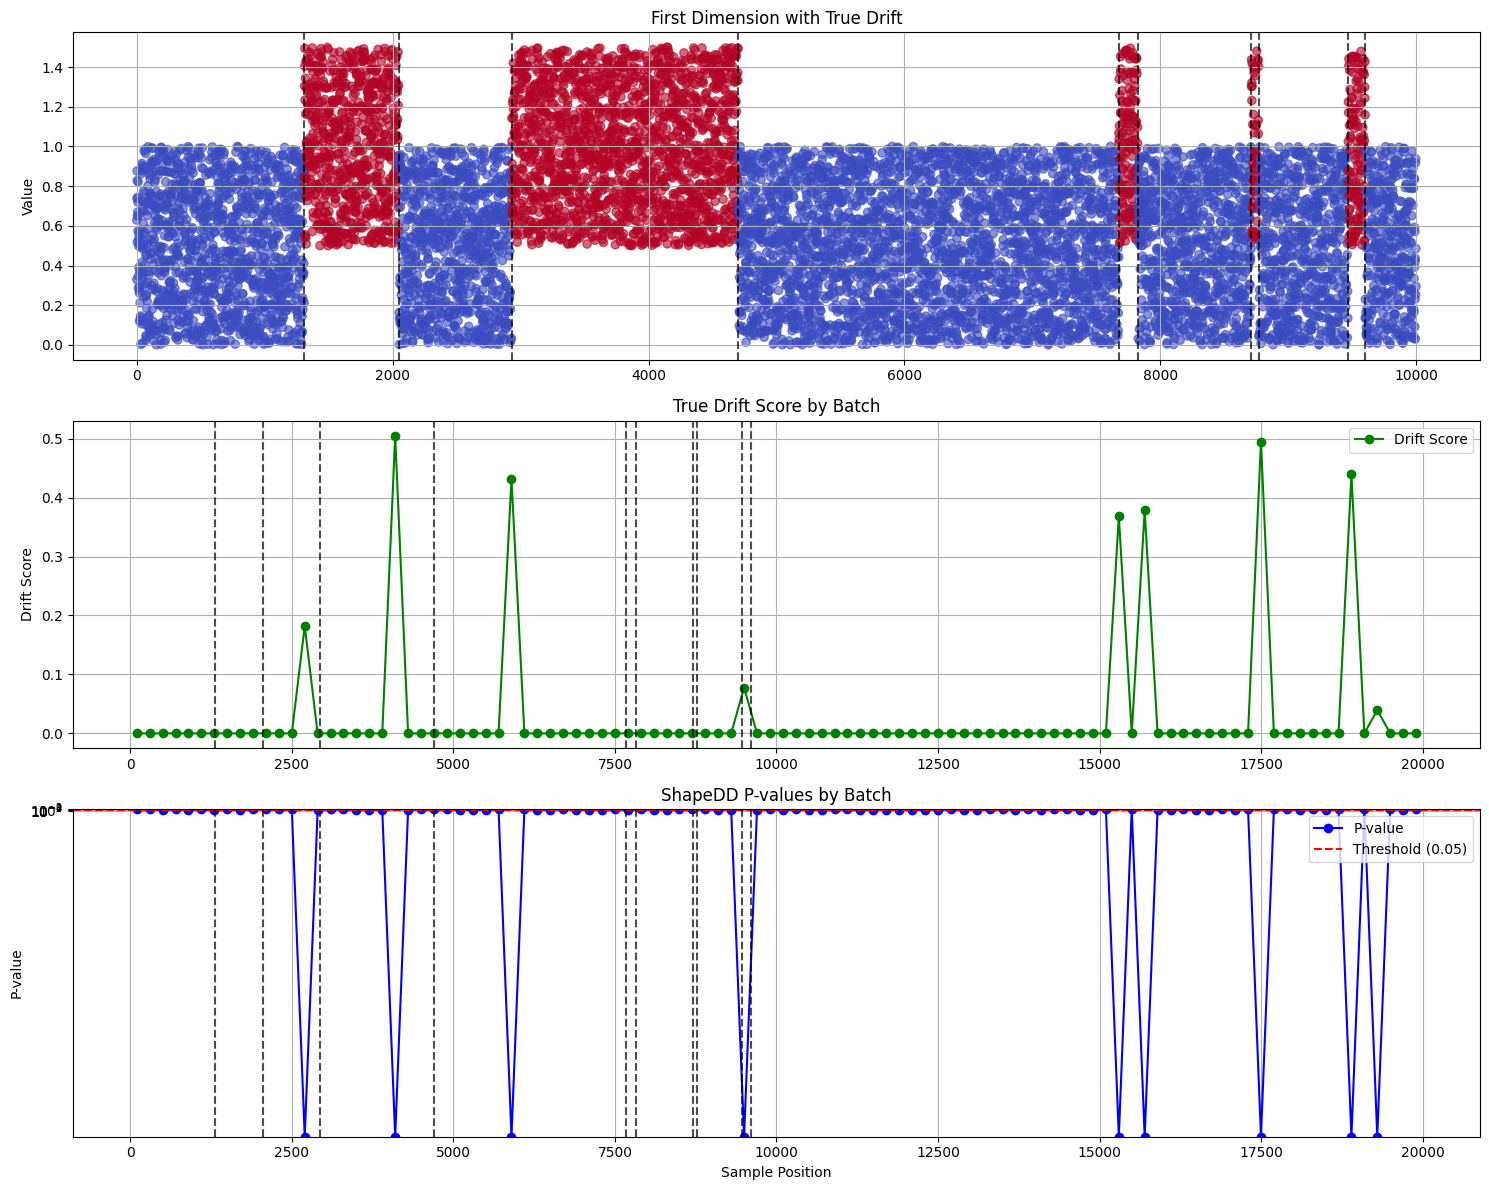

In [11]:
visualize_results(X, y, res_df)


# Modified version

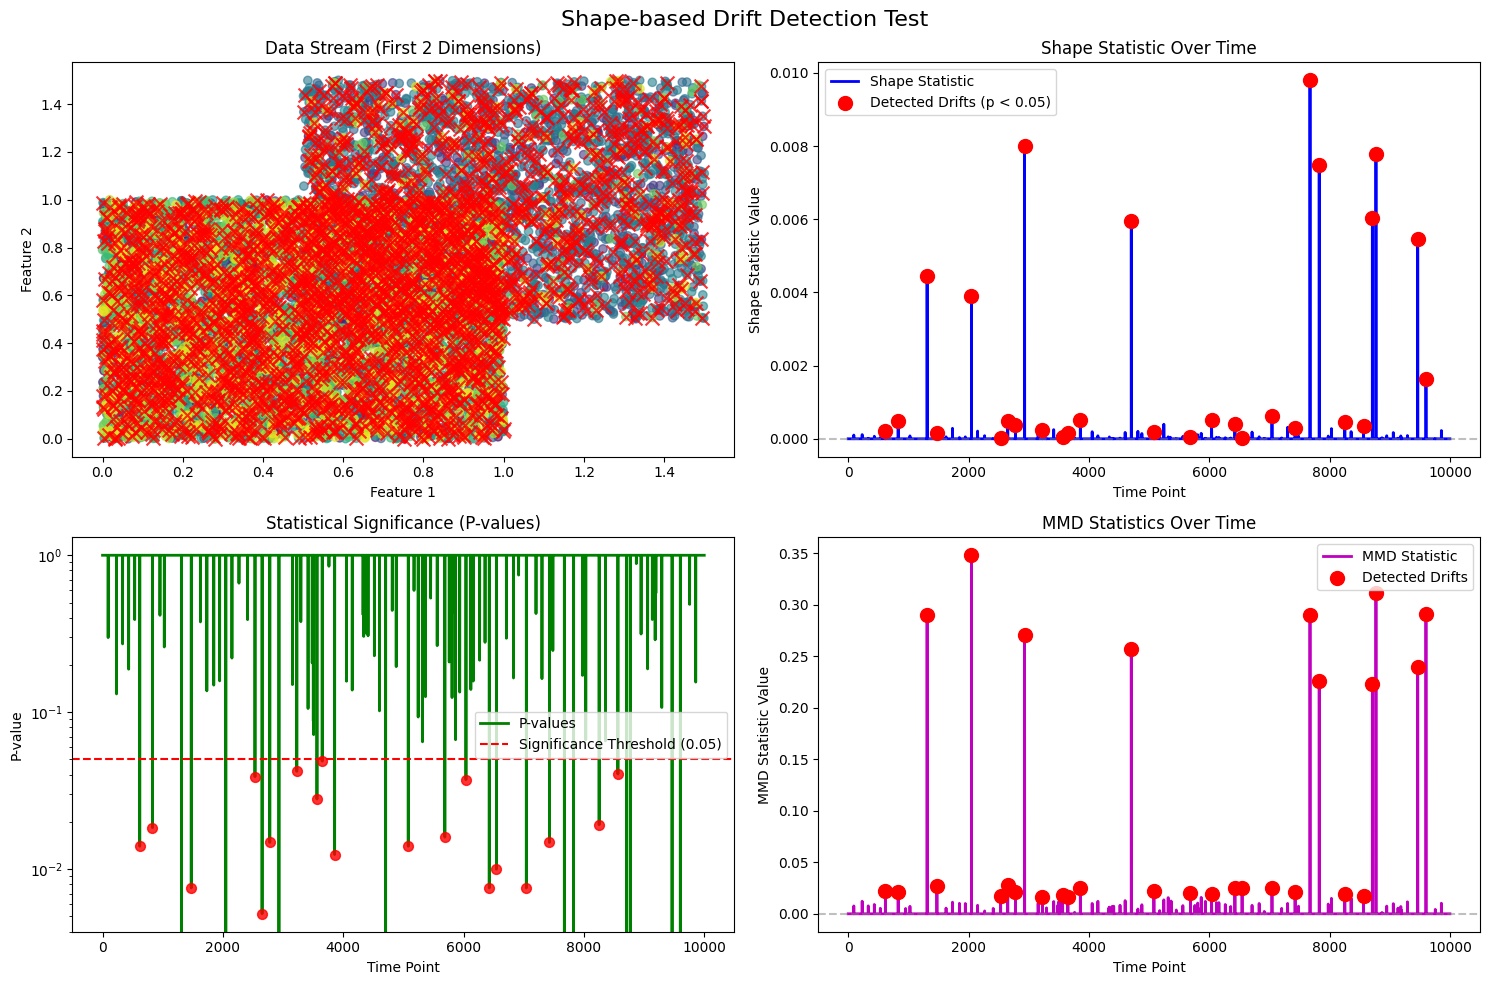


=== Drift Detection Summary ===
Number of significant drift points detected: 29
Drift positions: [np.int64(618), np.int64(830), np.int64(1311), np.int64(1474), np.int64(2048), np.int64(2533), np.int64(2651), np.int64(2779), np.int64(2931), np.int64(3228), np.int64(3563), np.int64(3650), np.int64(3857), np.int64(4704), np.int64(5080), np.int64(5688), np.int64(6039), np.int64(6426), np.int64(6545), np.int64(7042), np.int64(7426), np.int64(7674), np.int64(7827), np.int64(8252), np.int64(8564), np.int64(8710), np.int64(8770), np.int64(9464), np.int64(9601)]
P-value threshold: 0.05
Drift 1: Position 618, Shape stat: 0.0002, MMD stat: 0.0225, P-value: 0.014000
Drift 2: Position 830, Shape stat: 0.0005, MMD stat: 0.0212, P-value: 0.018400
Drift 3: Position 1311, Shape stat: 0.0044, MMD stat: 0.2907, P-value: 0.000000
Drift 4: Position 1474, Shape stat: 0.0002, MMD stat: 0.0271, P-value: 0.007600
Drift 5: Position 2048, Shape stat: 0.0039, MMD stat: 0.3482, P-value: 0.000000
Drift 6: Position

In [12]:
result = shape_modified(X, l1 = 50, l2 = 100, n_perm = 2500, 
                          plot=True, 
                          p_threshold=0.05,
                          title="Shape-based Drift Detection Test")


# Drift Detection for Incremental Drift dataset

In [36]:
# Importing necessary libraries
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import roc_auc_score as roc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import pairwise_kernels as apply_kernel
from shape_dd import shape, shape_modified
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import multiprocessing
from multiprocessing.pool import Pool
from tqdm import tqdm
import os
import random
import time
from gen_data import gen_random, gen_gradual_drift



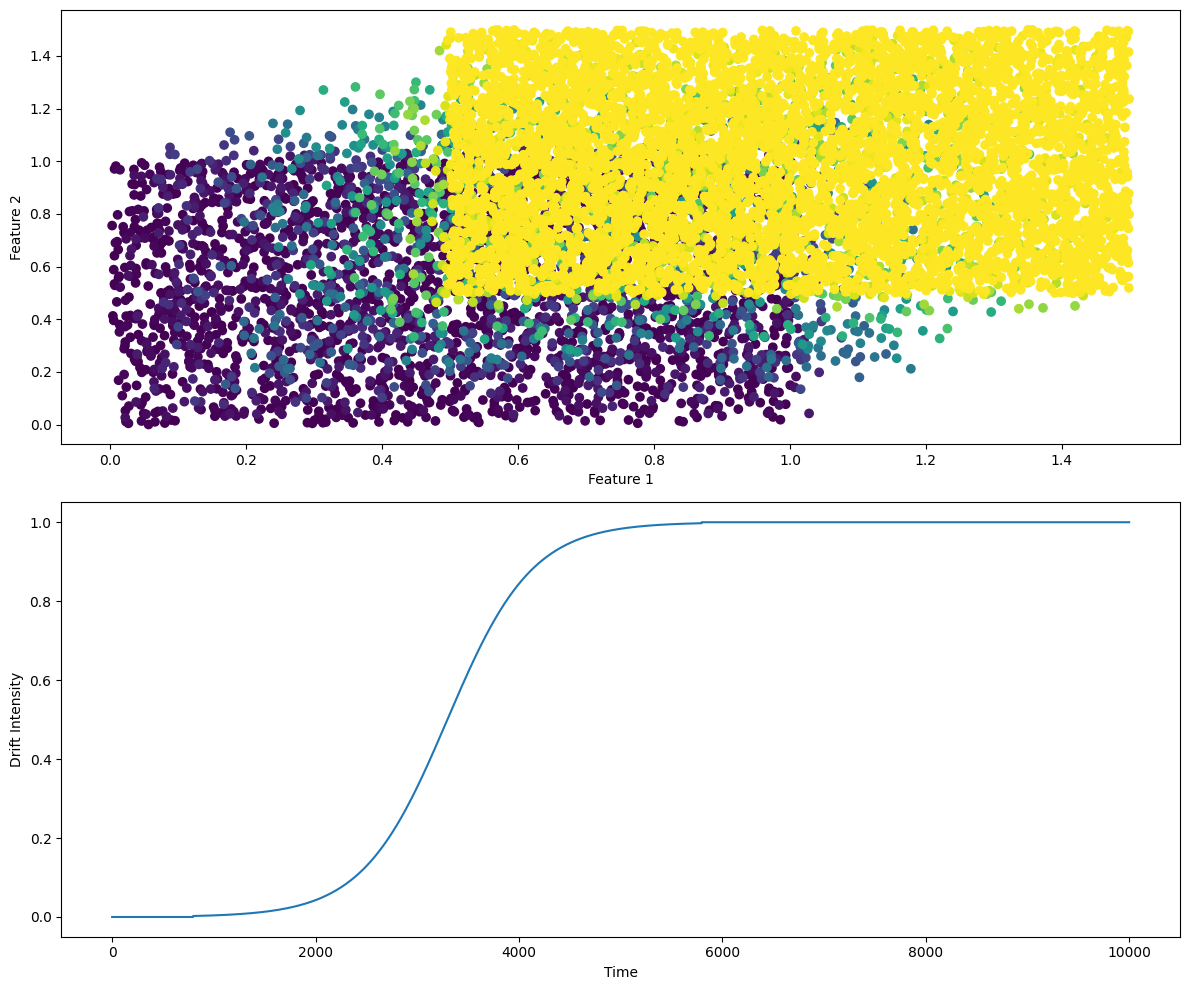

In [39]:
X_gradual, drift_indicator = gen_gradual_drift(
    number=1, dims=2, intens=0.5, dist="unif", length=10000,
    drift_type="sigmoid", transition_length=5000
)
# Create comparison plots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot gradual drift
axes[0].scatter(X_gradual[:,0], X_gradual[:,1], c=drift_indicator, cmap='viridis')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

axes[1].plot(drift_indicator)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Drift Intensity')

plt.tight_layout()
plt.show()


In [40]:
# Batch function to split the data into chunks with no overlap
def batch(X, chunk_size, overlap=0): # Change overlap to 0
    shift = chunk_size-overlap
    res = []
    for i in range(int(X.shape[0]/(shift))-int(chunk_size/shift)+1):
        res.append( X[i*shift : min(chunk_size + i*shift, X.shape[0])] )
    return res


In [41]:
batches = batch(np.arange(X_gradual.shape[0]), chunk_size= 100)


In [42]:
shp = shape(X_gradual, l1 = 50, l2 = 100, n_perm = 2500)



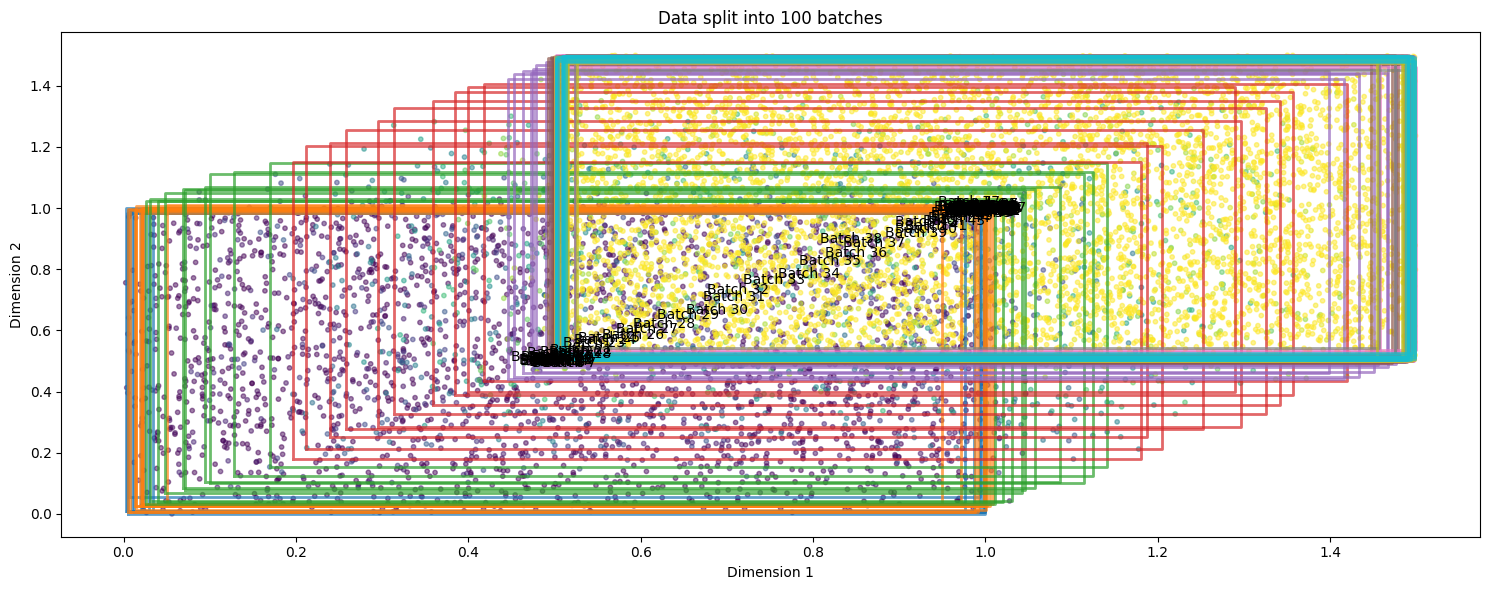

In [43]:
# Function to plot the batches
def plot_batches(X, batches, y=None):
    plt.figure(figsize=(15, 6))
    
    # Plot the first two dimensions of the data
    if X.shape[1] >= 2:
        plt.scatter(X[:, 0], X[:, 1], c=y if y is not None else 'blue', 
                   alpha=0.5, s=10, cmap='viridis')
        
        # Highlight the batches with different colors
        colors = plt.cm.tab10(np.linspace(0, 1, len(batches)))
        
        for i, batch_indices in enumerate(batches):
            batch_start = min(batch_indices)
            batch_end = max(batch_indices)
            
            # Draw rectangle around the batch
            x_min, x_max = X[batch_indices, 0].min(), X[batch_indices, 0].max()
            y_min, y_max = X[batch_indices, 1].min(), X[batch_indices, 1].max()
            
            plt.plot([x_min, x_max, x_max, x_min, x_min], 
                     [y_min, y_min, y_max, y_max, y_min], 
                     '-', color=colors[i], alpha=0.7, linewidth=2)
            
            # Add batch number
            plt.text((x_min + x_max)/2, (y_min + y_max)/2, f"Batch {i}", 
                    color='black', fontsize=10, ha='center', va='center')
    
    else:
        # If data has only one dimension, plot it against indices
        plt.scatter(range(len(X)), X[:, 0], c=y if y is not None else 'blue', 
                   alpha=0.5, s=10, cmap='viridis')
        
        # Highlight the batches
        for i, batch_indices in enumerate(batches):
            plt.axvspan(min(batch_indices), max(batch_indices), 
                       alpha=0.2, color=plt.cm.tab10(i/10))
            plt.text(np.mean(batch_indices), plt.ylim()[0], f"Batch {i}", 
                    ha='center', va='bottom')
    
    plt.title(f"Data split into {len(batches)} batches")
    plt.xlabel("Dimension 1" if X.shape[1] >= 2 else "Index")
    plt.ylabel("Dimension 2" if X.shape[1] >= 2 else "Value")
    plt.tight_layout()
    plt.show()

# Plot the batches
plot_batches(X_gradual, batches, drift_indicator)


In [44]:
# Calculate the shape statistic for each batch
res = []
for b in batches:
    # Get the batch
    X_ = X_gradual[b]
    
    # Calculate the drift score for the batch
    drift_score = (drift_indicator[b][None,:] != drift_indicator[b][:,None]).sum() / (b.shape[0] * (b.shape[0]-1))

    # Calculate the shape statistic for the batch
    shp_stat_min = float("%.5f" % shp[b, 0].min())
    mmd_stat_min = float("%.5f" % shp[b, 1].min())
    p_value_min = float("%.5f" % shp[b, 2].min())
    
    # Add the results to the list
    result = {
        # "batch_id": i,
        "batch_start": min(b),
        "batch_end": max(b),
        "drift_score": drift_score,
        "shape_stat_min": shp_stat_min,
        "mmd_stat_min": mmd_stat_min,
        "p_value": p_value_min
    }
    res.append(result)

# Convert the results to a DataFrame
res_df = pd.DataFrame(res)




In [45]:
def visualize_results(X, y, results_df):
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot 1: Original data with true drift
    axes[0].scatter(range(len(X)), X[:, 0], c=y if y is not None else 'blue', 
                cmap='coolwarm', alpha=0.6)
    axes[0].set_title('First Dimension with True Drift')
    axes[0].set_ylabel('Value')
    # axes[0].grid(True)
    
    # Plot 2: Drift scores (if available)
    if 'drift_score' in results_df.columns:
        batch_centers = (results_df['batch_start'] + results_df['batch_end'])
        axes[1].plot(batch_centers, results_df['drift_score'], 'o-g', label='Drift Score')
        axes[1].set_title('True Drift Score by Batch')
        axes[1].set_ylabel('Drift Score')
        axes[1].grid(True)
        axes[1].legend()
    

    # Plot 4: P-values
    batch_centers = (results_df['batch_start'] + results_df['batch_end'])
    axes[2].plot(batch_centers, results_df['p_value'], 'o-b', label='P-value')
    axes[2].axhline(y=0.05, color='r', linestyle='--', label='Threshold (0.05)')
    axes[2].set_ylim(0, 1)
    axes[2].set_title('ShapeDD P-values by Batch')
    axes[2].set_xlabel('Sample Position')
    axes[2].set_ylabel('P-value')
    axes[2].set_yscale('log')
    axes[2].grid(True)
    axes[2].legend()
    
    
    plt.tight_layout()
    plt.show()


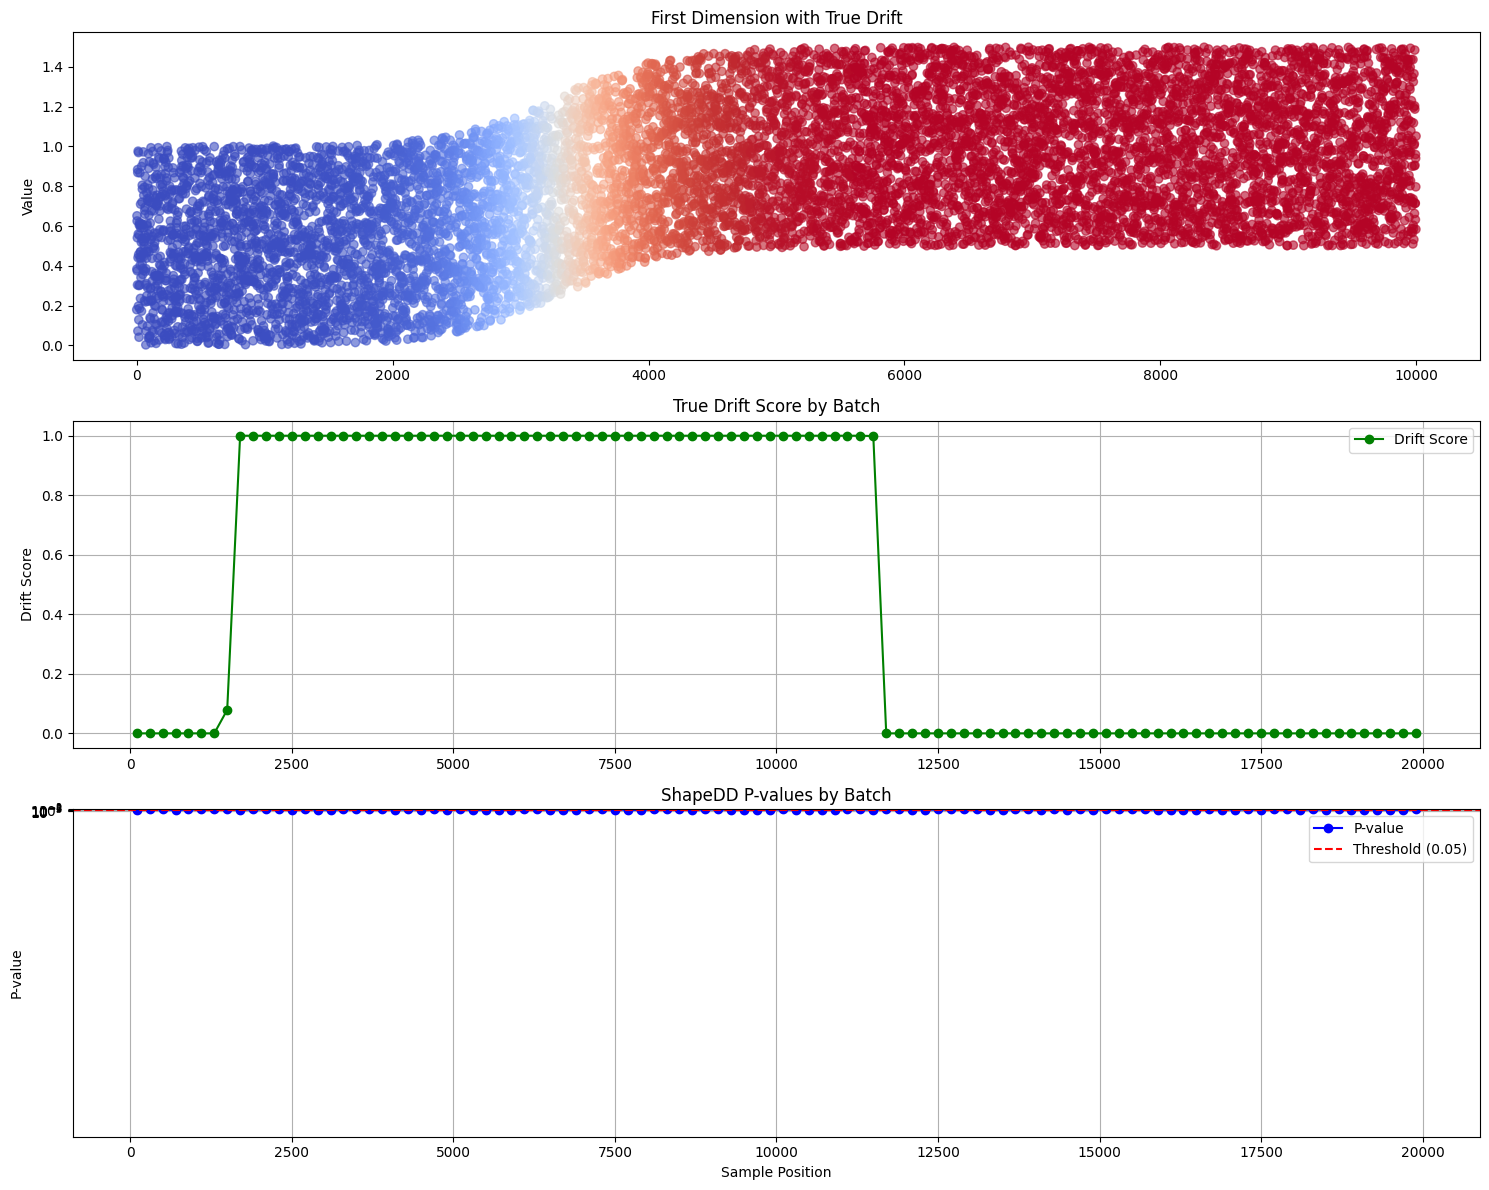

In [46]:
visualize_results(X_gradual, drift_indicator, res_df)


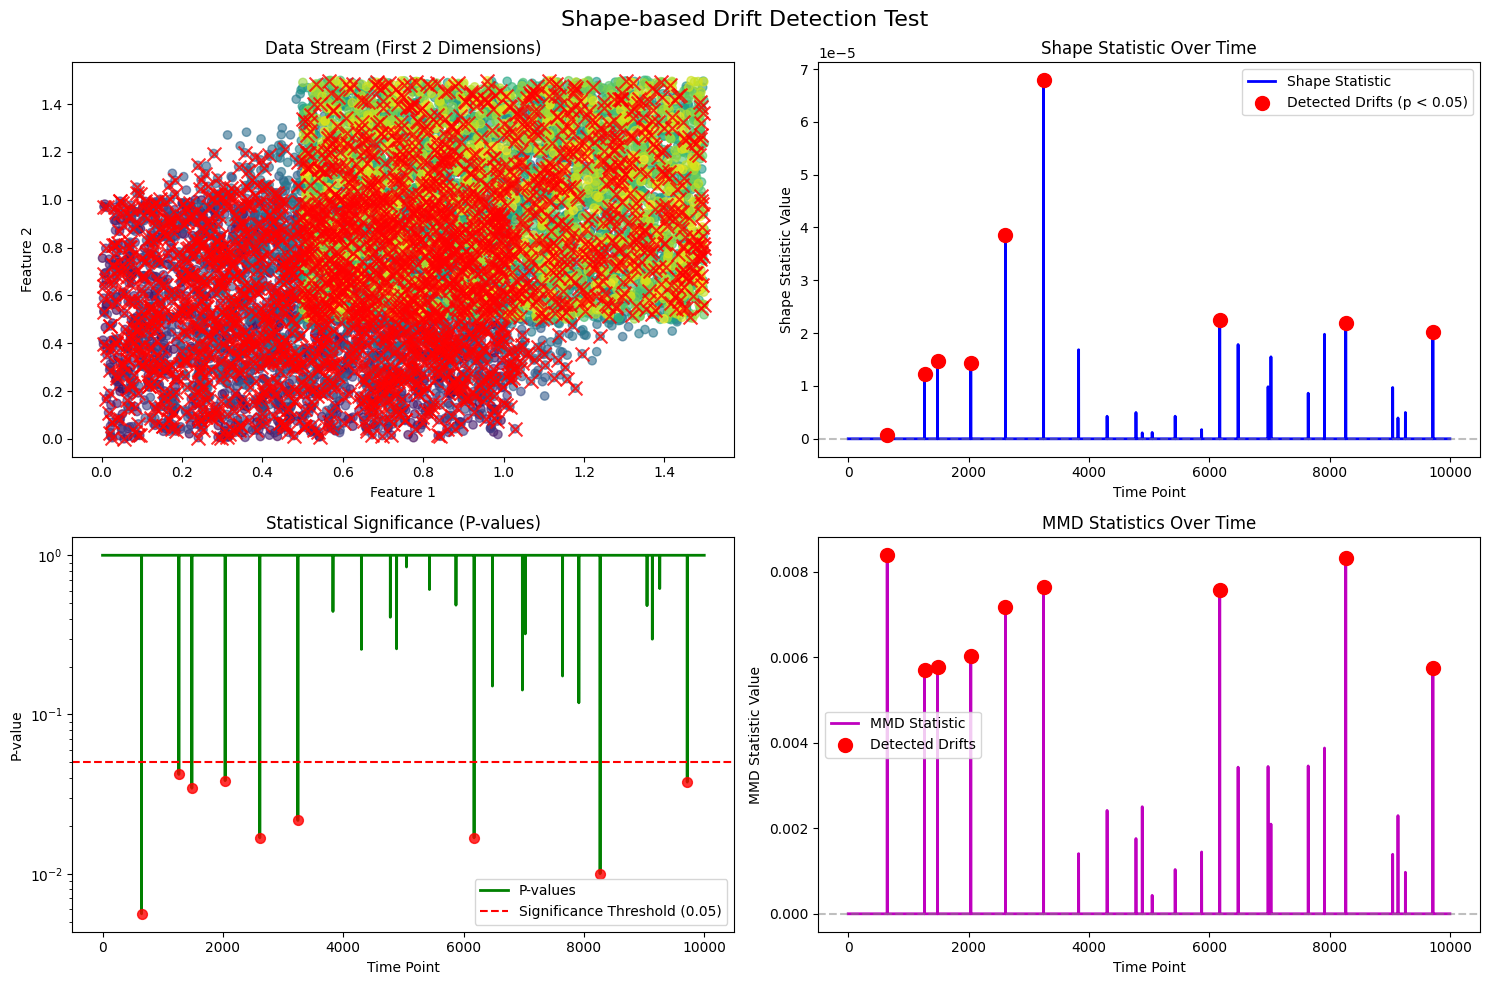


=== Drift Detection Summary ===
Number of significant drift points detected: 9
Drift positions: [np.int64(648), np.int64(1268), np.int64(1484), np.int64(2037), np.int64(2613), np.int64(3246), np.int64(6174), np.int64(8268), np.int64(9716)]
P-value threshold: 0.05
Drift 1: Position 648, Shape stat: 0.0000, MMD stat: 0.0084, P-value: 0.005600
Drift 2: Position 1268, Shape stat: 0.0000, MMD stat: 0.0057, P-value: 0.042000
Drift 3: Position 1484, Shape stat: 0.0000, MMD stat: 0.0058, P-value: 0.034400
Drift 4: Position 2037, Shape stat: 0.0000, MMD stat: 0.0060, P-value: 0.038400
Drift 5: Position 2613, Shape stat: 0.0000, MMD stat: 0.0072, P-value: 0.016800
Drift 6: Position 3246, Shape stat: 0.0001, MMD stat: 0.0077, P-value: 0.021600
Drift 7: Position 6174, Shape stat: 0.0000, MMD stat: 0.0076, P-value: 0.016800
Drift 8: Position 8268, Shape stat: 0.0000, MMD stat: 0.0083, P-value: 0.010000
Drift 9: Position 9716, Shape stat: 0.0000, MMD stat: 0.0057, P-value: 0.037600


In [53]:
result = shape_modified(X_gradual, l1 = 200, l2 = 300, n_perm = 2500, 
                          plot=True, 
                          p_threshold=0.05,
                          title="Shape-based Drift Detection Test")


# Drift Detection for open source dataset

In [7]:
X = pd.read_csv('../THU-Concept-Drift-Datasets-v1.0/Harvard_Concept_Drift_Datasets/rt_2563789698568873_gradual.csv')
X


X1        X2  class
0      0.550284  0.918541    0.0
1      0.564631  0.409379    0.0
2      0.430762  0.624576    0.0
3      0.662184  0.154598    0.0
4      0.266372  0.541274    1.0
...         ...       ...    ...
40995  0.842049  0.729838    1.0
40996  0.492425  0.974886    1.0
40997  0.370881  0.079075    1.0
40998  0.714709  0.093885    0.0
40999  0.046967  0.248966    1.0

[41000 rows x 3 columns]

In [8]:
y = X['class']
y = np.array(y)


In [9]:
X.drop(columns=['class'], inplace=True)
X


X1        X2
0      0.550284  0.918541
1      0.564631  0.409379
2      0.430762  0.624576
3      0.662184  0.154598
4      0.266372  0.541274
...         ...       ...
40995  0.842049  0.729838
40996  0.492425  0.974886
40997  0.370881  0.079075
40998  0.714709  0.093885
40999  0.046967  0.248966

[41000 rows x 2 columns]

In [10]:
X = np.array(X)


In [11]:
X


array([[0.55028363, 0.91854123],
       [0.56463062, 0.40937861],
       [0.43076236, 0.62457551],
       ...,
       [0.37088069, 0.07907513],
       [0.714709  , 0.09388542],
       [0.04696742, 0.24896599]])

In [13]:
y


array([0., 0., 0., ..., 1., 0., 1.])

In [30]:
# Batch function to split the data into chunks with no overlap
def batch(X, chunk_size, overlap=0): # Change overlap to 0
    shift = chunk_size-overlap
    res = []
    for i in range(int(X.shape[0]/(shift))-int(chunk_size/shift)+1):
        res.append( X[i*shift : min(chunk_size + i*shift, X.shape[0])] )
    return res


In [31]:
batches = batch(np.arange(X.shape[0]), chunk_size= 100)


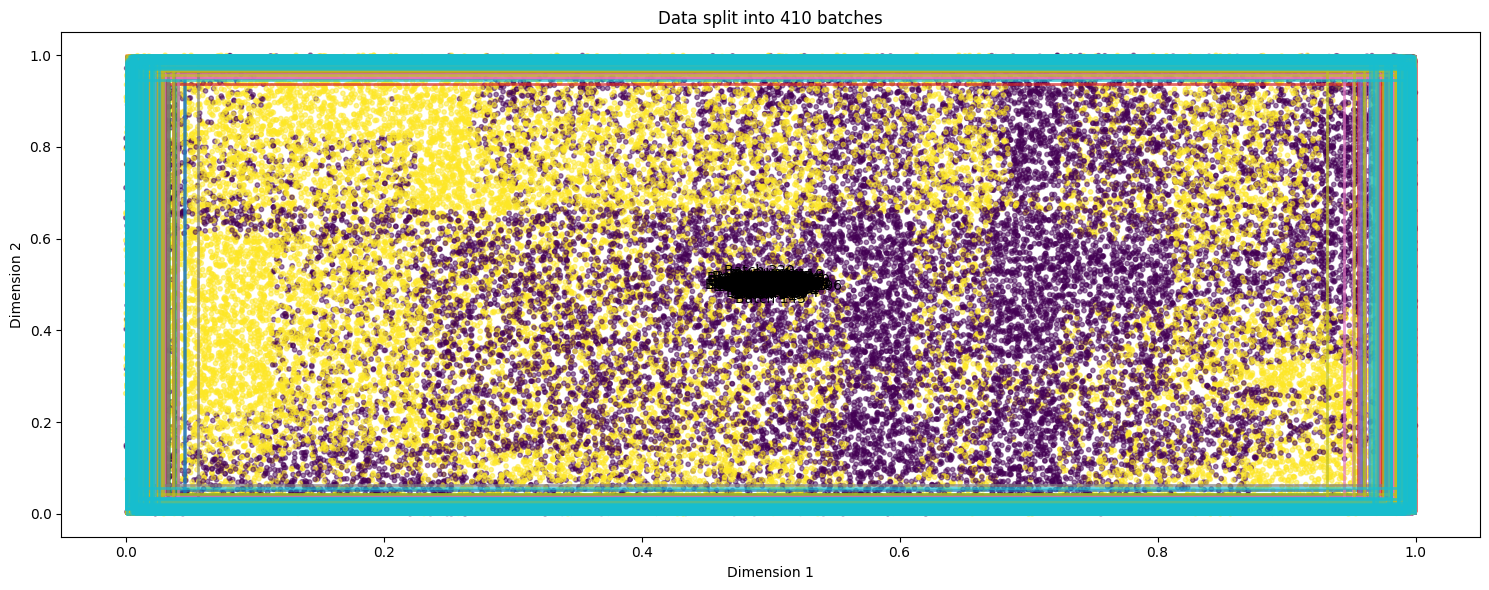

In [32]:
# Function to plot the batches
def plot_batches(X, batches, y=None):
    plt.figure(figsize=(15, 6))
    
    # Plot the first two dimensions of the data
    if X.shape[1] >= 2:
        plt.scatter(X[:, 0], X[:, 1], c=y if y is not None else 'blue', 
                   alpha=0.5, s=10, cmap='viridis')
        
        # Highlight the batches with different colors
        colors = plt.cm.tab10(np.linspace(0, 1, len(batches)))
        
        for i, batch_indices in enumerate(batches):
            batch_start = min(batch_indices)
            batch_end = max(batch_indices)
            
            # Draw rectangle around the batch
            x_min, x_max = X[batch_indices, 0].min(), X[batch_indices, 0].max()
            y_min, y_max = X[batch_indices, 1].min(), X[batch_indices, 1].max()
            
            plt.plot([x_min, x_max, x_max, x_min, x_min], 
                     [y_min, y_min, y_max, y_max, y_min], 
                     '-', color=colors[i], alpha=0.7, linewidth=2)
            
            # Add batch number
            plt.text((x_min + x_max)/2, (y_min + y_max)/2, f"Batch {i}", 
                    color='black', fontsize=10, ha='center', va='center')
    
    else:
        # If data has only one dimension, plot it against indices
        plt.scatter(range(len(X)), X[:, 0], c=y if y is not None else 'blue', 
                   alpha=0.5, s=10, cmap='viridis')
        
        # Highlight the batches
        for i, batch_indices in enumerate(batches):
            plt.axvspan(min(batch_indices), max(batch_indices), 
                       alpha=0.2, color=plt.cm.tab10(i/10))
            plt.text(np.mean(batch_indices), plt.ylim()[0], f"Batch {i}", 
                    ha='center', va='bottom')
    
    plt.title(f"Data split into {len(batches)} batches")
    plt.xlabel("Dimension 1" if X.shape[1] >= 2 else "Index")
    plt.ylabel("Dimension 2" if X.shape[1] >= 2 else "Value")
    plt.tight_layout()
    plt.show()

# Plot the batches
plot_batches(X, batches, y)


In [33]:
# Calculate the shape statistic for the entire dataset
# l1 is the number of points to use for the shape statistic
# chunk_size is the number of points to use for the shape statistic
# n_perm is the number of permutations to use for the shape statistic
# shp = shape(X, l1 = 50, l2 = 100, n_perm = 2500)[:,2]
shp = shape(X, l1 = 50, l2 = 100, n_perm = 2500)
# Run the experiment


: 

In [ ]:
# Calculate the shape statistic for each batch
res = []
for b in batches:
    # Get the batch
    X_ = X[b]
    
    # Calculate the drift score for the batch
    drift_score = (y[b][None,:] != y[b][:,None]).sum() / (b.shape[0] * (b.shape[0]-1))

    # Calculate the shape statistic for the batch
    shp_stat_min = float("%.5f" % shp[b, 0].min())
    mmd_stat_min = float("%.5f" % shp[b, 1].min())
    p_value_min = float("%.5f" % shp[b, 2].min())
    
    # Add the results to the list
    result = {
        # "batch_id": i,
        "batch_start": min(b),
        "batch_end": max(b),
        "drift_score": drift_score,
        "shape_stat_min": shp_stat_min,
        "mmd_stat_min": mmd_stat_min,
        "p_value": p_value_min
    }
    res.append(result)

# Convert the results to a DataFrame
res_df = pd.DataFrame(res)




In [ ]:
def visualize_results(X, y, results_df):
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot 1: Original data with true drift
    axes[0].scatter(range(len(X)), X[:, 0], c=y if y is not None else 'blue', 
                cmap='coolwarm', alpha=0.6)
    axes[0].set_title('First Dimension with True Drift')
    axes[0].set_ylabel('Value')
    axes[0].grid(True)
    
    # Plot 2: Drift scores (if available)
    if 'drift_score' in results_df.columns:
        batch_centers = (results_df['batch_start'] + results_df['batch_end'])
        axes[1].plot(batch_centers, results_df['drift_score'], 'o-g', label='Drift Score')
        axes[1].set_title('True Drift Score by Batch')
        axes[1].set_ylabel('Drift Score')
        axes[1].grid(True)
        axes[1].legend()
    

    # Plot 4: P-values
    batch_centers = (results_df['batch_start'] + results_df['batch_end'])
    axes[2].plot(batch_centers, results_df['p_value'], 'o-b', label='P-value')
    axes[2].axhline(y=0.05, color='r', linestyle='--', label='Threshold (0.05)')
    axes[2].set_ylim(0, 1)
    axes[2].set_title('ShapeDD P-values by Batch')
    axes[2].set_xlabel('Sample Position')
    axes[2].set_ylabel('P-value')
    axes[2].set_yscale('log')
    axes[2].grid(True)
    axes[2].legend()
    
    # Add true drift change points if available
    if y is not None:
        true_drift_positions = np.where(np.diff(y) != 0)[0]
        for ax in axes:
            for pos in true_drift_positions:
                ax.axvline(x=pos, color='black', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()


In [ ]:
visualize_results(X, y, res_df)


In [ ]:
result = shape_modified(X, l1 = 50, l2 = 100, n_perm = 2500, 
                          plot=True, 
                          p_threshold=0.05,
                          title="Shape-based Drift Detection Test")


In [33]:
X = np.array([
    [0.2, 0.3],   # First distribution cluster
    [-0.1, 0.4],
    [0.3, 0.2],
    [0.1, 0.3],
    [9.8, 9.9],   # Second distribution cluster
    [10.2, 10.1],
    [9.9, 10.2],
    [10.1, 9.8]
])


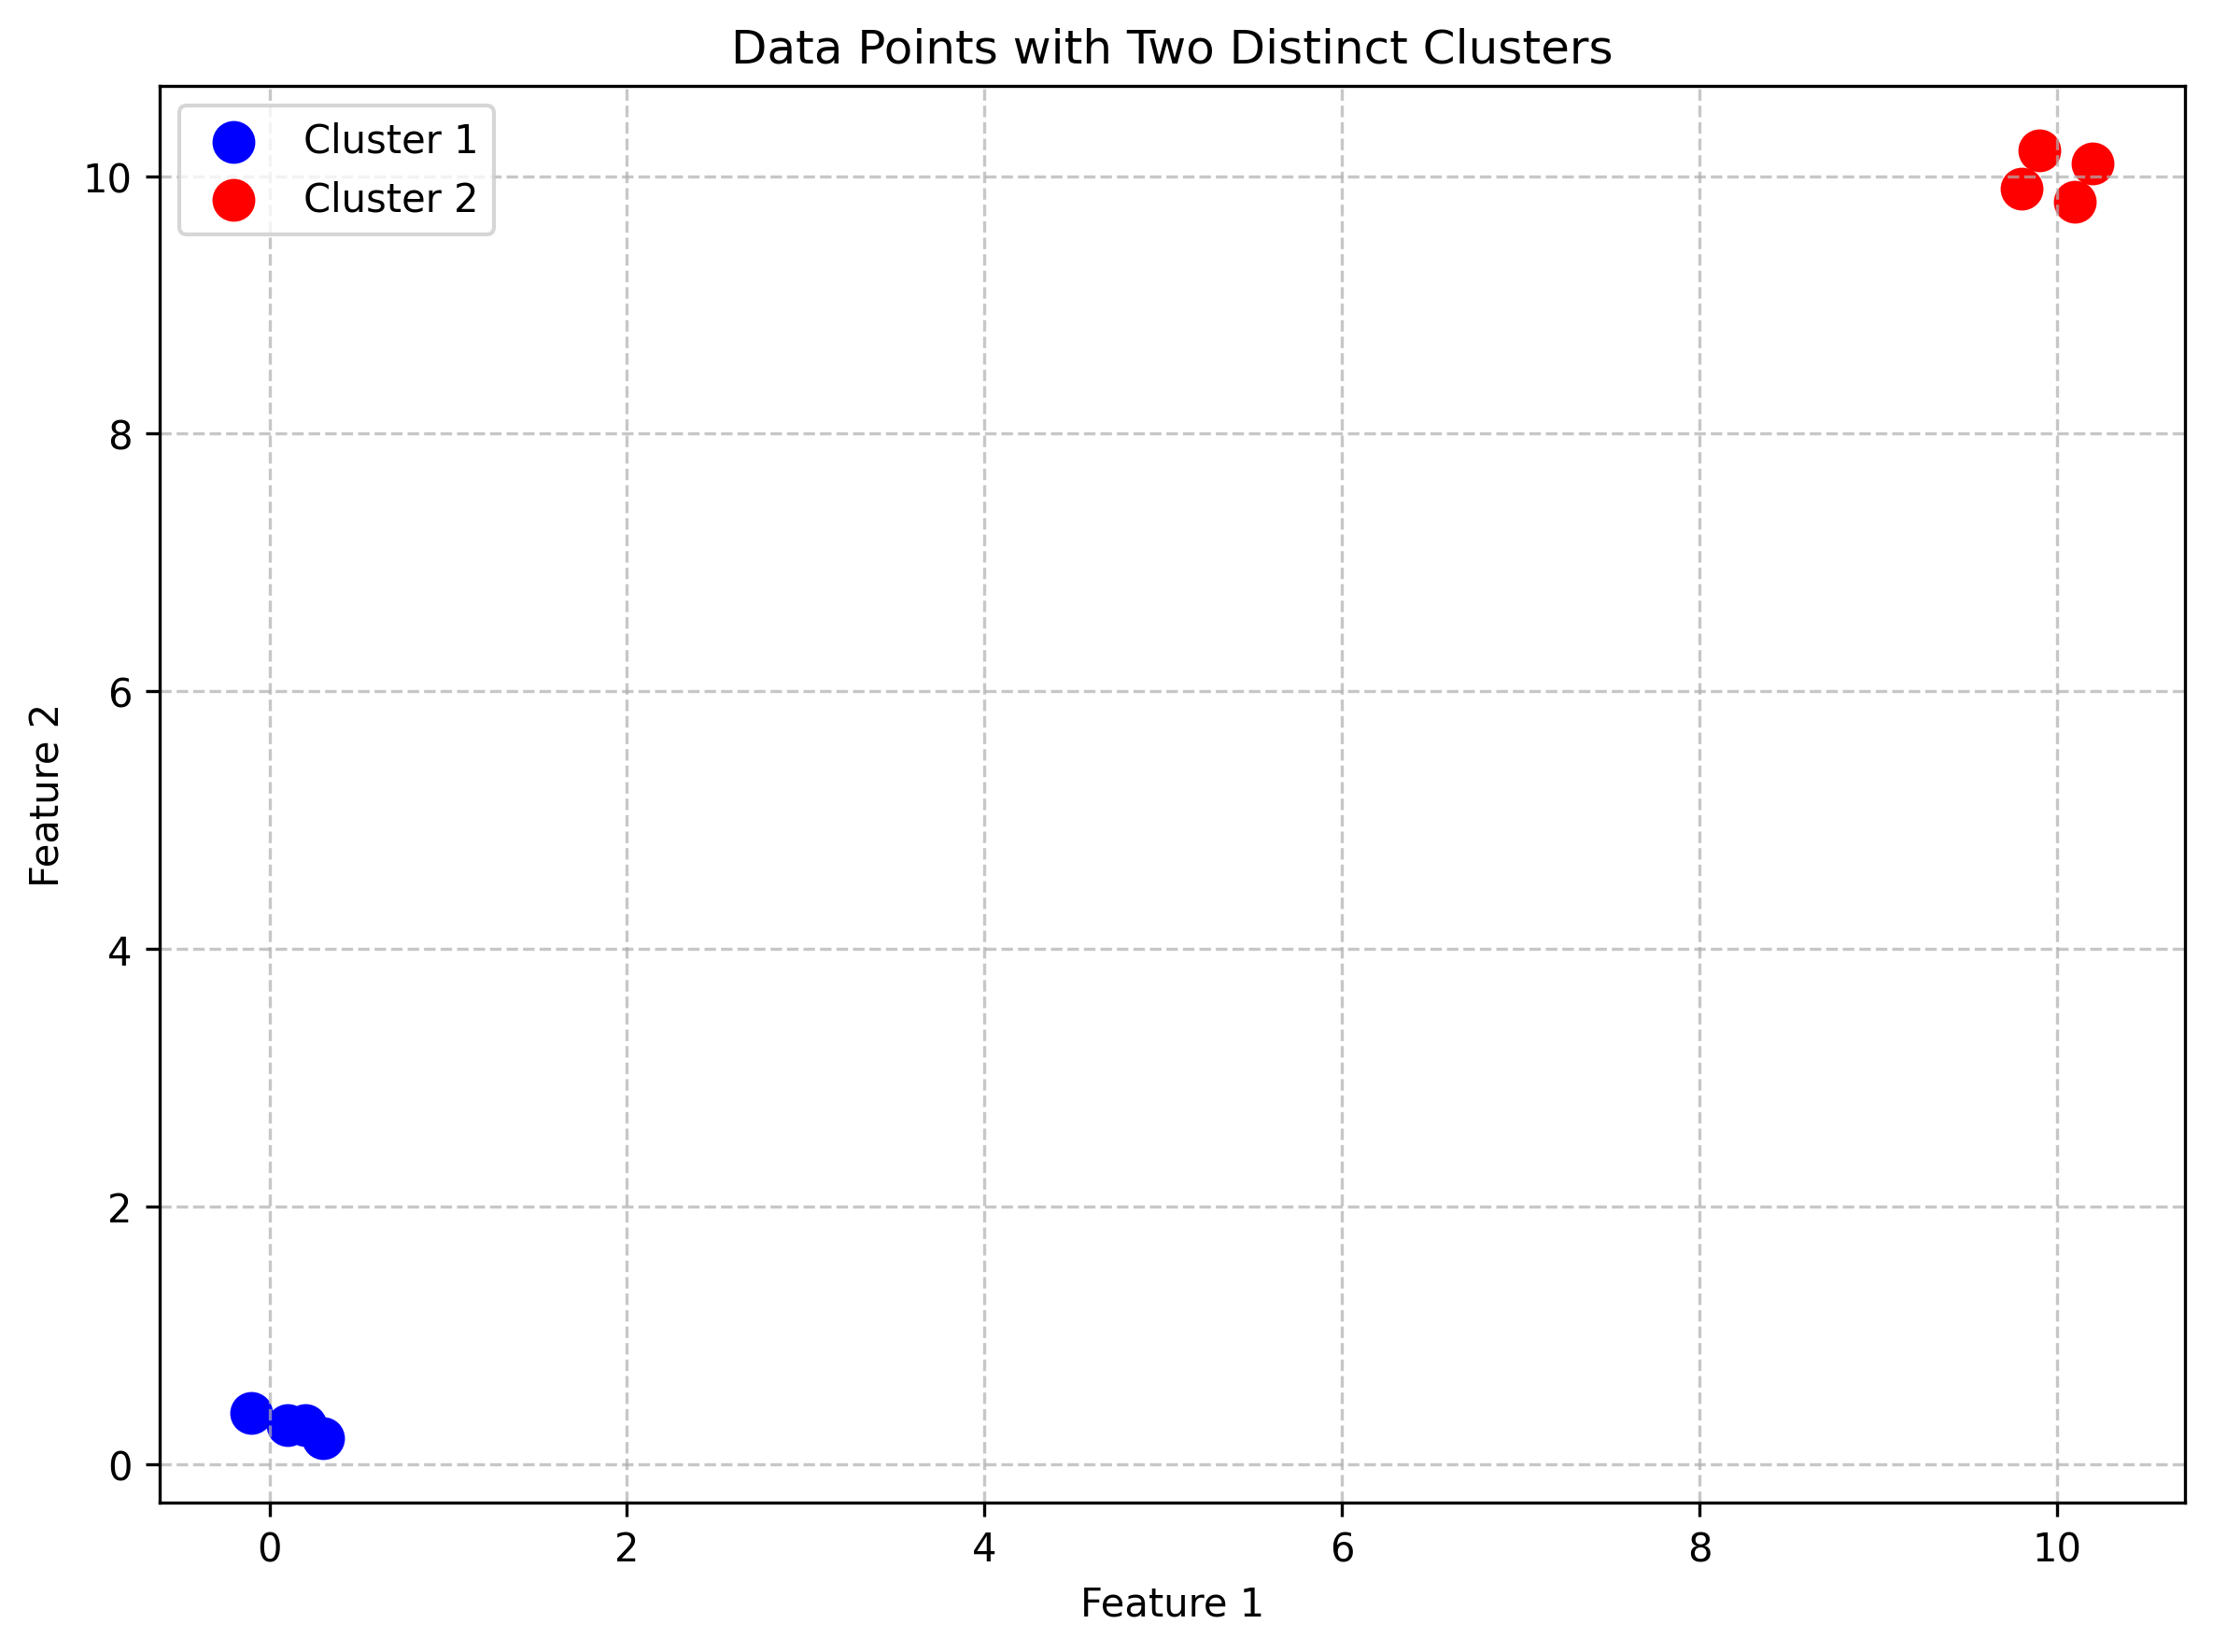

In [50]:
# Create a figure with high DPI for better quality
plt.figure(figsize=(8, 6), dpi=300)

# Plot the data points with different colors for each cluster
plt.scatter(X[:4, 0], X[:4, 1], c='blue', s=100, label='Cluster 1')
plt.scatter(X[4:, 0], X[4:, 1], c='red', s=100, label='Cluster 2')

# Add labels and title
plt.title('Data Points with Two Distinct Clusters', fontsize=12)
plt.xlabel('Feature 1', fontsize=10)
plt.ylabel('Feature 2', fontsize=10)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

# Adjust layout and save with high quality
plt.tight_layout()
plt.savefig('clusters.png', bbox_inches='tight', dpi=300)
plt.show()


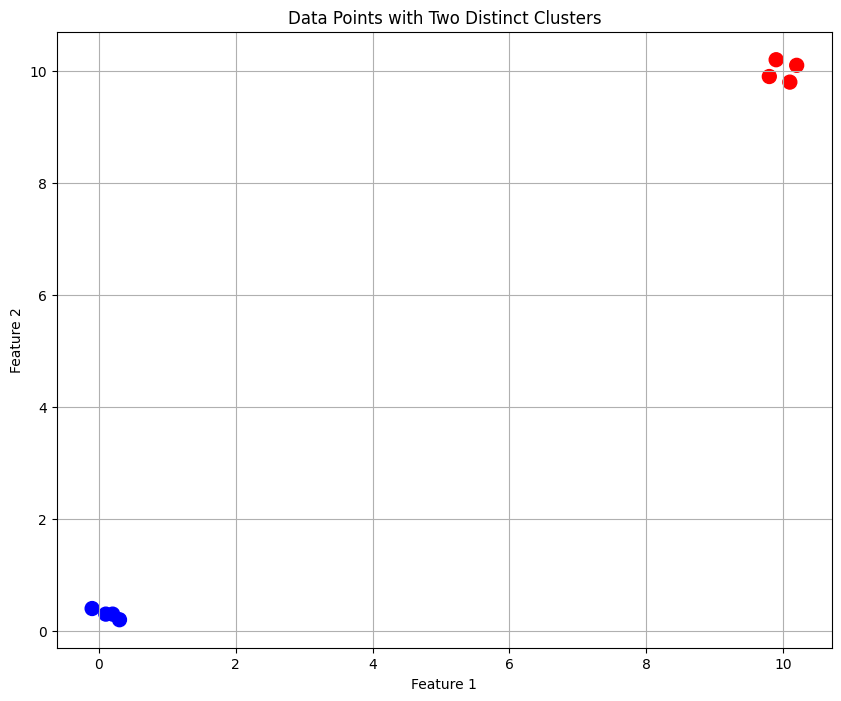

In [34]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=['blue']*4 + ['red']*4, s=100)
plt.title('Data Points with Two Distinct Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()


In [35]:
K = apply_kernel(X, metric="rbf")


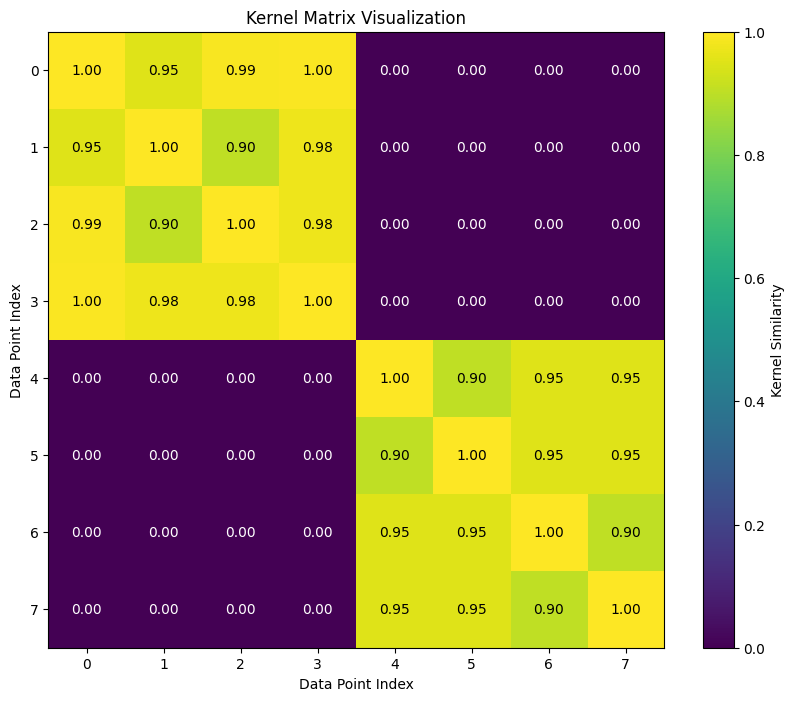

In [36]:
# Visualize the kernel matrix K to show similarity between data points
plt.figure(figsize=(10, 8))
plt.imshow(K, cmap='viridis')
plt.colorbar(label='Kernel Similarity')
plt.title('Kernel Matrix Visualization')
plt.xlabel('Data Point Index')
plt.ylabel('Data Point Index')

# Add annotations to show the cluster structure
for i in range(len(X)):
    for j in range(len(X)):
        plt.text(j, i, f'{K[i,j]:.2f}', 
                ha='center', va='center',
                color='white' if K[i,j] < 0.5 else 'black')

plt.show()



In [37]:
l1 = 2
w = np.array(l1*[1.] + l1*[-1.]) / float(l1)


In [38]:
w.shape


(4,)

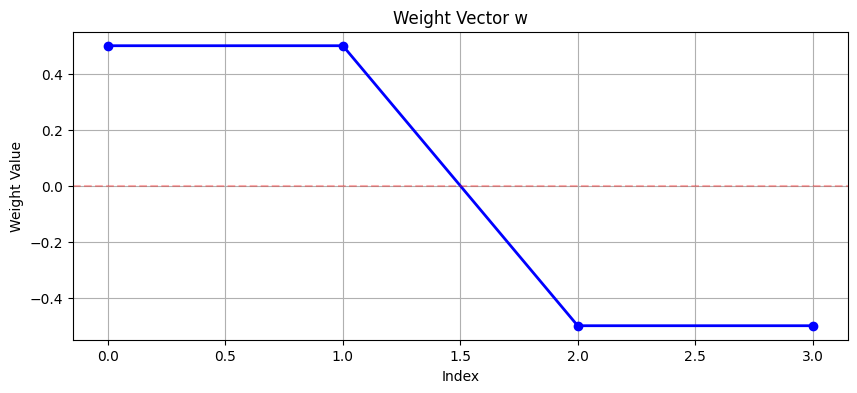

In [39]:
plt.figure(figsize=(10, 4))
plt.plot(w, 'bo-', linewidth=2)
plt.title('Weight Vector w')
plt.xlabel('Index')
plt.ylabel('Weight Value')
plt.grid(True)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.show()


In [40]:
n = X.shape[0]
W = np.zeros((n-2*l1, n))
for i in range(n-2*l1):
    W[i,i:i+2*l1] = w    


print(W)


[[ 0.5  0.5 -0.5 -0.5  0.   0.   0.   0. ]
 [ 0.   0.5  0.5 -0.5 -0.5  0.   0.   0. ]
 [ 0.   0.   0.5  0.5 -0.5 -0.5  0.   0. ]
 [ 0.   0.   0.   0.5  0.5 -0.5 -0.5  0. ]]


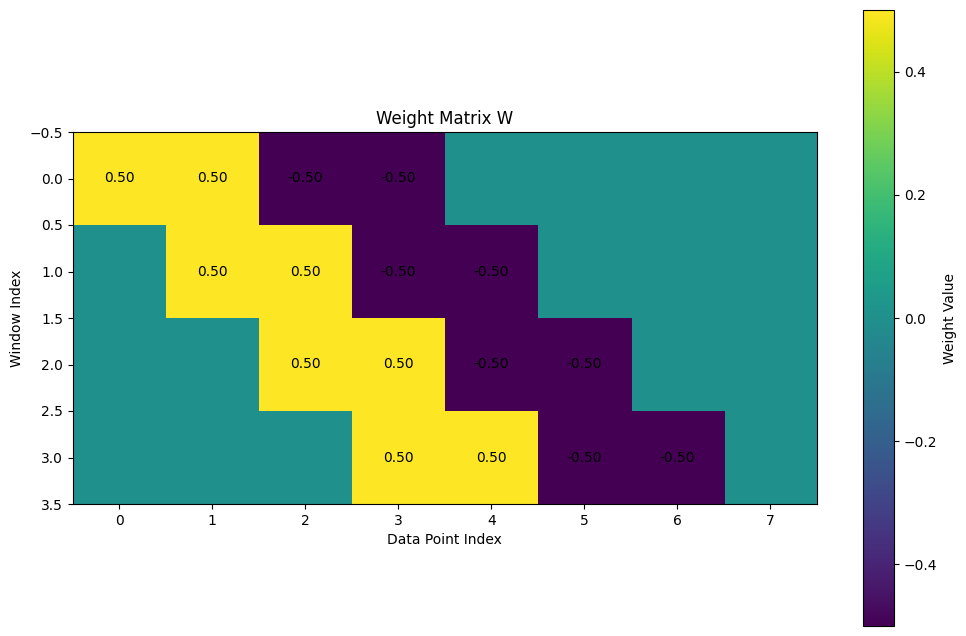

In [41]:
plt.figure(figsize=(12, 8))
plt.imshow(W, cmap='viridis')
plt.colorbar(label='Weight Value')
plt.title('Weight Matrix W')
plt.xlabel('Data Point Index')
plt.ylabel('Window Index')

# Add annotations to show the weight values
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        if W[i,j] != 0:  # Only show non-zero values
            plt.text(j, i, f'{W[i,j]:.2f}', 
                    ha='center', va='center',
                    color='white' if abs(W[i,j]) > 0.5 else 'black')

plt.show()



In [42]:
stat = np.einsum('ij,ij->i', np.dot(W, K), W)


In [43]:
stat


array([0.03066485, 0.4771088 , 1.94007367, 0.54758129])

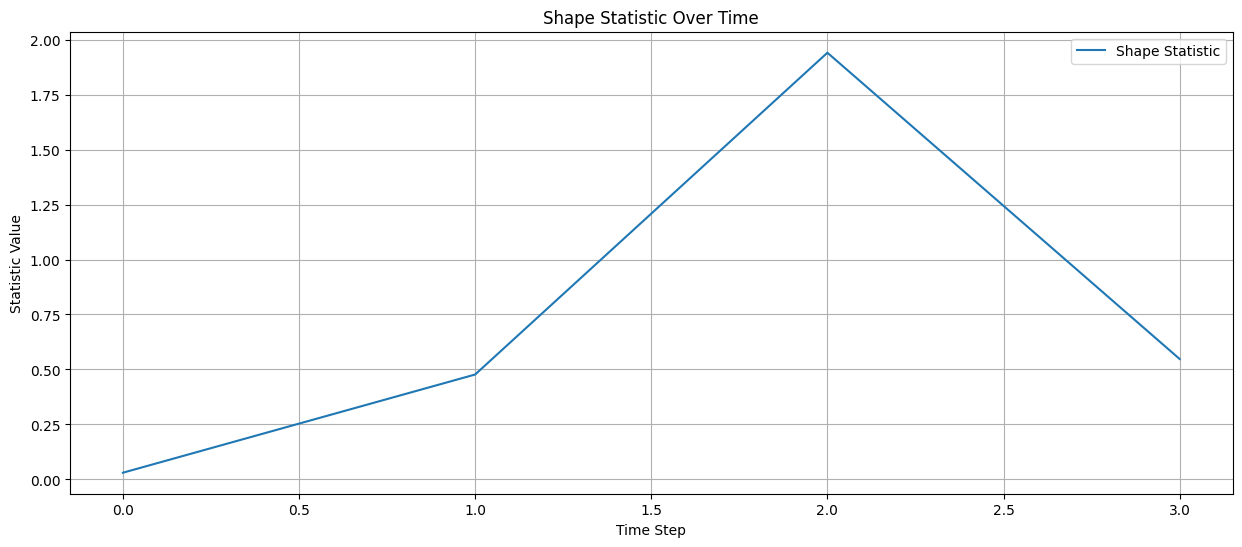

In [44]:
plt.figure(figsize=(15, 6))
plt.plot(stat, label='Shape Statistic')
plt.title('Shape Statistic Over Time')
plt.xlabel('Time Step')
plt.ylabel('Statistic Value')
plt.grid(True)
plt.legend()
plt.show()


In [46]:
shape_values = np.convolve(stat,w)
shape_prime = shape_values[1:]*shape_values[:-1] 


In [48]:
shape_values


array([ 0.01533242,  0.25388682,  1.19325881,  0.98994066, -0.93480059,
       -1.24382748, -0.27379065])

In [47]:
shape_prime


array([ 0.0038927 ,  0.30295269,  1.18125541, -0.9253971 ,  1.16273065,
        0.34054833])

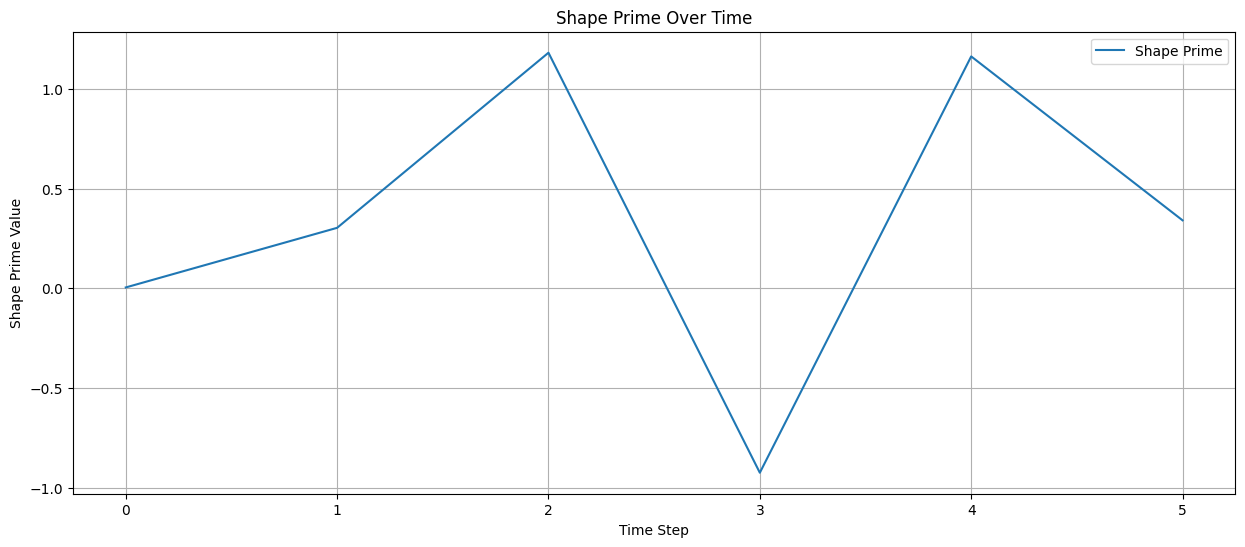

In [49]:
plt.figure(figsize=(15, 6))
plt.plot(shape_prime, label='Shape Prime')
plt.title('Shape Prime Over Time')
plt.xlabel('Time Step')
plt.ylabel('Shape Prime Value')
plt.grid(True)
plt.legend()
plt.show()


In [52]:
from mmd import mmd

l2 = 3 

res = np.zeros((n,3))
res[:,2] = 1
for pos in np.where(shape_prime < 0)[0]:
    if shape_values[pos] > 0:
        res[pos,0] = shape_values[pos]
        a,b = max(0,pos-int(l2/2)),min(n,pos+int(l2/2))
        res[pos,1:] = mmd(X[a:b], pos-a, n_perm = 2500)



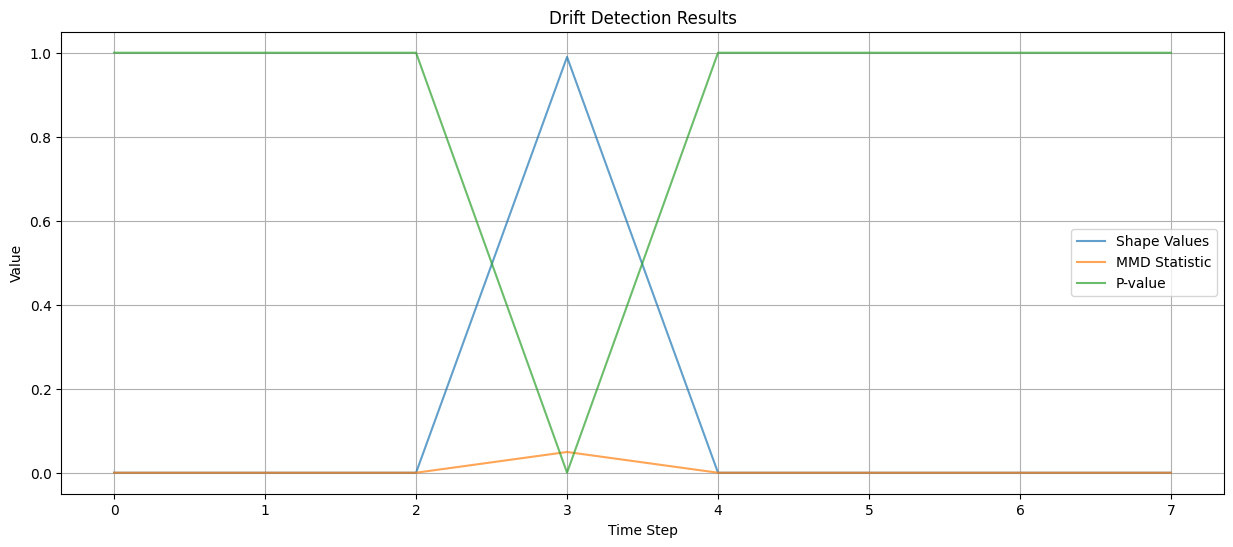

In [53]:
plt.figure(figsize=(15, 6))
plt.plot(res[:, 0], label='Shape Values', alpha=0.7)
plt.plot(res[:, 1], label='MMD Statistic', alpha=0.7)
plt.plot(res[:, 2], label='P-value', alpha=0.7)
plt.title('Drift Detection Results')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()


# Experiment with Elec Dataset

## Import the dataset